In [55]:
import mrcnn
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import MaskRCNN, log
from keras.models import load_model
from mrcnn.utils import Dataset
from mrcnn import utils



import numpy as np
from numpy import zeros
from numpy import asarray

import argparse
import imutils
import cv2
import os
import json
from PIL import Image, ImageDraw
import pandas as pd
import random
import skimage.draw
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon, Rectangle

%matplotlib inline

# current directory that stores train and val folders
dataset_dir = r"C:\Users\steven\Mask_RCNN\samples\linkedin"
COCO_MODEL_PATH = r"C:\Users\steven\Mask_RCNN\mask_rcnn_coco.h5"
MODEL_DIR = r"C:\Users\steven\Mask_RCNN"

In [56]:
class LinkedinBar(Config):
    # give the configuration a recognizable name
    NAME = "lkdBar"
     #number of classes (we would normally add +1 for the background)
     # more + report 
    NUM_CLASSES = 3
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=3
   
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 3
   

In [57]:
config = LinkedinBar()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [75]:
class linkedinDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, subset):
        # Add classes. We have only one class to add.
        self.add_class("buttons", 1, "more")
        self.add_class("buttons", 2, "report")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values()) 
        
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations]
      
        # Add images
        
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                objects = [r['region_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 
                objects = [r['region_attributes'] for r in a['regions']]

            num_ids = [list(n.values()) for n in objects]
            num_ids = [[1], [2]]
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "buttons",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                num_ids=num_ids,
                width=width, height=height,
                polygons=polygons)
            
        
    def load_mask(self, image_id):
       
        info = self.image_info[image_id]
    
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        mask = np.zeros([info["height"],
                         info["width"],
                         len(info["polygons"])],
                         dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        # Map class names to class IDs.
        num_ids = info['num_ids']
        num_ids = np.array(num_ids, dtype=np.int32)
        num_ids = np.ndarray.flatten(num_ids)
        
        return mask.astype(np.bool), num_ids
                 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "buttons":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [76]:
# Load dataset
dataset = linkedinDataset()
dataset.load_dataset(dataset_dir, subset = 'train')
# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 69
Class Count: 3
  0. BG                                                
  1. more                                              
  2. report                                            


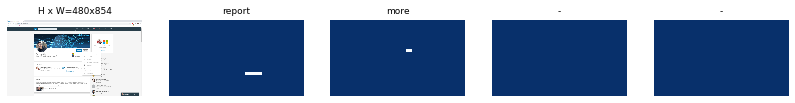

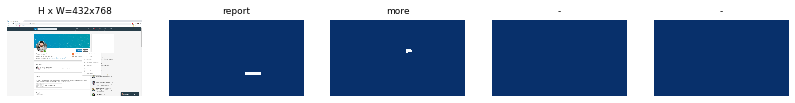

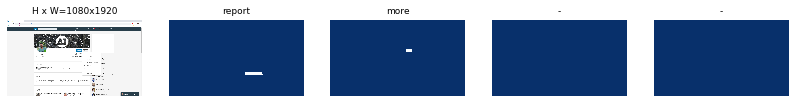

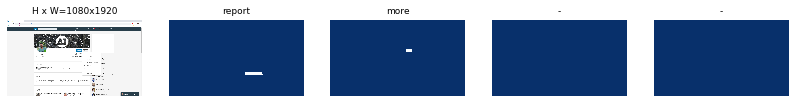

In [77]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  66 C:\Users\steven\Mask_RCNN\samples\linkedin\train\90.png
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1080, 1920, 2)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:  408.00000  max: 1326.00000  int32


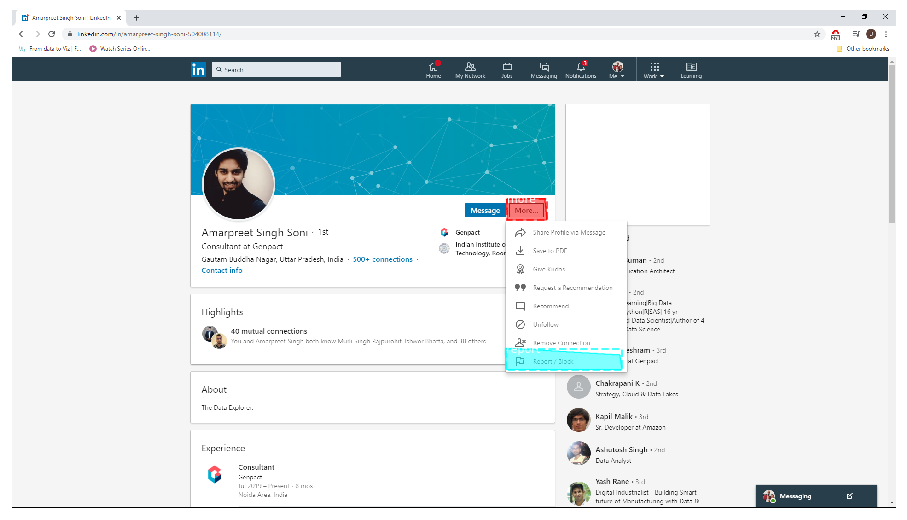

In [78]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)


# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [79]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


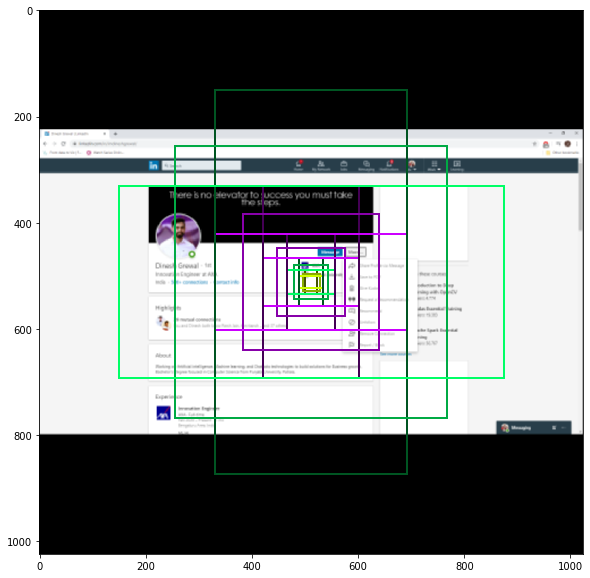

In [66]:
# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

In [80]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", 
                          config=config,
                          model_dir=MODEL_DIR)

In [81]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights

    model.load_weights(
        COCO_MODEL_PATH,
        by_name=True,
        exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask",
            "rpn_model"  # because anchor's ratio has been changed
        ])
elif init_with == "last":
    # Load the last model you trained and conptinue training
    model.load_weights(model.find_last(), by_name=True)

In [82]:
# Training dataset.
dataset_train = linkedinDataset()
dataset_train.load_dataset(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = linkedinDataset()
dataset_val.load_dataset(dataset_dir, "val")
dataset_val.prepare()

# *** This training schedule is an example. Update to your needs ***
# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(dataset_train,
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=5,
            layers='heads')

Training network heads

Starting at epoch 0. LR=0.006

Checkpoint Path: C:\Users\steven\Mask_RCNN\lkdbar20200208T1917\mask_rcnn_lkdbar_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeD

C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
  8/100 [=>............................] - ETA: 55:52 - loss: 3.3776 - rpn_class_loss: 0.6714 - rpn_bbox_loss: 2.2722 - mrcnn_class_loss: 0.4340 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'id': '80.png', 'source': 'buttons', 'path': 'C:\\Users\\steven\\Mask_RCNN\\samples\\linkedin\\train\\80.png', 'num_ids': [[1], [2]], 'width': 2688, 'height': 1242, 'polygons': [{'name': 'polygon', 'all_points_x': [1498, 1508, 1632, 1615], 'all_points_y': [431, 493, 497, 424]}]}
Traceback (most recent call last):
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1265, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1


  9/100 [=>............................] - ETA: 55:02 - loss: 3.1710 - rpn_class_loss: 0.6028 - rpn_bbox_loss: 2.1824 - mrcnn_class_loss: 0.3858 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'id': '81.png', 'source': 'buttons', 'path': 'C:\\Users\\steven\\Mask_RCNN\\samples\\linkedin\\train\\81.png', 'num_ids': [[1], [2]], 'width': 1280, 'height': 768, 'polygons': [{'name': 'polygon', 'all_points_x': [713, 720, 780, 771], 'all_points_y': [266, 307, 301, 265]}]}
Traceback (most recent call last):
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1265, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1


 31/100 [========>.....................] - ETA: 40:40 - loss: 1.9382 - rpn_class_loss: 0.2087 - rpn_bbox_loss: 1.6175 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'id': '79.png', 'source': 'buttons', 'path': 'C:\\Users\\steven\\Mask_RCNN\\samples\\linkedin\\train\\79.png', 'num_ids': [[1], [2]], 'width': 2000, 'height': 3000, 'polygons': [{'name': 'polygon', 'all_points_x': [1121, 1127, 1229, 1210], 'all_points_y': [1057, 1185, 1178, 1057]}]}
Traceback (most recent call last):
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1265, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1


 32/100 [========>.....................] - ETA: 40:05 - loss: 1.9105 - rpn_class_loss: 0.2036 - rpn_bbox_loss: 1.5984 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'id': '82.png', 'source': 'buttons', 'path': 'C:\\Users\\steven\\Mask_RCNN\\samples\\linkedin\\train\\82.png', 'num_ids': [[1], [2]], 'width': 1536, 'height': 2048, 'polygons': [{'name': 'polygon', 'all_points_x': [862, 862, 936, 931], 'all_points_y': [714, 809, 801, 714]}]}
Traceback (most recent call last):
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1265, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1


 36/100 [=========>....................] - ETA: 37:40 - loss: 1.8184 - rpn_class_loss: 0.1850 - rpn_bbox_loss: 1.5369 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'id': '79.png', 'source': 'buttons', 'path': 'C:\\Users\\steven\\Mask_RCNN\\samples\\linkedin\\train\\79.png', 'num_ids': [[1], [2]], 'width': 2000, 'height': 3000, 'polygons': [{'name': 'polygon', 'all_points_x': [1121, 1127, 1229, 1210], 'all_points_y': [1057, 1185, 1178, 1057]}]}
Traceback (most recent call last):
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1265, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1


 38/100 [==========>...................] - ETA: 36:28 - loss: 1.7874 - rpn_class_loss: 0.1774 - rpn_bbox_loss: 1.5187 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ERROR:root:Error processing image {'id': '82.png', 'source': 'buttons', 'path': 'C:\\Users\\steven\\Mask_RCNN\\samples\\linkedin\\train\\82.png', 'num_ids': [[1], [2]], 'width': 1536, 'height': 2048, 'polygons': [{'name': 'polygon', 'all_points_x': [862, 862, 936, 931], 'all_points_y': [714, 809, 801, 714]}]}
Traceback (most recent call last):
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\steven\Anaconda3\envs\tf\lib\site-packages\mask_rcnn-2.1-py3.7.egg\mrcnn\model.py", line 1265, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=6, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
model_path = r"C:\Users\steven\Mask_RCNN\samples\linkedin\weights"  + '.' + 'first' + '.h5'
model.keras_model.save_weights(model_path)

In [70]:
# Create model in training mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir= MODEL_DIR)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [71]:
# load in prior weights
model.load_weights(model.find_last(), by_name=True)

FileNotFoundError: [Errno 2] Could not find weight files in C:\Users\steven\Mask_RCNN\lkdbar20200208T1913

In [ ]:
# Load validation dataset
dataset = linkedinDataset()
dataset.load_dataset(dataset_dir, subset = 'val')
# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# run detection
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)